In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTForMaskedImageModeling
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from vit_model import ViTForMultitask3, ViTForImageClassification2


os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [16]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)
# def load_data(): 
#     dataset = load_dataset("mrm8488/ImageNet1K-val")
#     dataset = dataset['train']
#     splits = dataset.train_test_split(test_size=0.1, seed=42)
#     test_ds = splits['test']
#     splits = splits['train'].train_test_split(test_size=0.1, seed=42)
#     train_ds = splits['train']
#     val_ds = splits['test']
#     return train_ds, val_ds, test_ds

# train_ds, val_ds, test_ds = load_data()

# image = train_ds[1]['image']

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'nonorm-vit-base-patch16-224-finetuned-imageneteval/checkpoint-520'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval/checkpoint-79'

# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

inputs = processor(images=image, return_tensors="pt")
inputs.to(device)
outputs = pred_model(**inputs, output_hidden_states=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


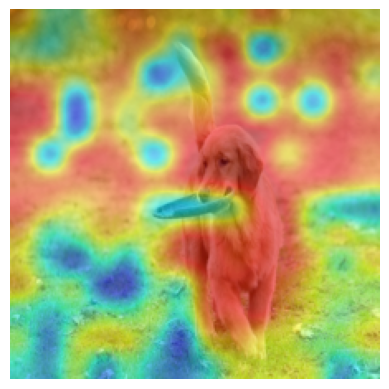

In [17]:
def get_pyx_prime(model, outputs):
    """
    Obtain p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        model: a ViT model
        outputs: the outputs of the ViT model given input x
    Returns:
        pyx: p(y|x)
        pyx_prime: p(y|x')
    """
    image_embeds = outputs.hidden_states[-1] # [N, L+1, d]
    image_embeds = model.vit.layernorm(image_embeds) # [N, L+1, d]
    # image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    # image_embeds_diff = image_embeds[:,0:1, :] - image_embeds
    # logits_diff = model.classifier(image_embeds_diff) # [N, L+1, 1000]
    logits = model.classifier(image_embeds) # [N, L+1, 1000]

    logits = torch.softmax(logits, dim=-1)

    pyx = logits[:, 0:1, :] # [N, 1, 1000]
    pyx_prime = logits[:, 1:, :] # [N, L, 1000]
    return pyx, pyx_prime

def get_heatmap(pyx, pyx_prime):
    """
    Given p(y|x) and p(y|x'), where x' is the input with the ith entry missing.
    Args:
        pyx: [N, 1, 1000]
        pyx_prime: [N, L, 1000]

    Returns: 
        heatmap: [N, 14, 14, 1000]
    """
    # res = (pyx - pyx_prime) # [N, L, N]
    res = pyx_prime
    N_v, L, N_t = res.shape
    res = (res>0).float() * res
    
    heatmap = res.reshape(N_v,14,14, N_t).detach().cpu().numpy()
    return heatmap

def unnormalize(img, mean, std):
    mean = np.array(mean).reshape(1,1,3)
    std = np.array(std).reshape(1,1,3)
    return img * std + mean

def convert_to_255_scale(img):
    return (img * 255).astype(np.uint8)

def unnormalize_and_255_scale(img, mean, std):
    return convert_to_255_scale(unnormalize(img,mean,std))

def show_superimposed(img, heatmap):
    cv2_image = cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(heatmap,(13,13), 11)

def normalize_and_rescale(heatmap):
    max_value = np.max(heatmap)
    min_value = np.min(heatmap)
    heatmap_ft = (heatmap - min_value) / (max_value - min_value) # float point
    return convert_to_255_scale(heatmap_ft) # int8

def get_overlap(image, heatmap):
    return cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

def plot_overlap(image, heatmap):
    overlap = get_overlap(image, heatmap)
    plt.imshow(overlap)
    plt.axis('off')
    plt.show()
    return 0

def plot_overlap_np(image, heatmap, img_mean, img_std):
    shape = image.shape[:2]
    heatmap = normalize_and_rescale(heatmap)
    resized_heatmap = cv2.resize(heatmap, shape)
    blur = cv2.blur(resized_heatmap ,(13,13), 11)
    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
    heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)

    image = unnormalize_and_255_scale(image, img_mean, img_std)
    
    plot_overlap(image, heatmap_img)
    return image, heatmap_img

pyx, pyx_prime = get_pyx_prime(pred_model, outputs)
heatmap = get_heatmap(pyx, pyx_prime)[0,:,:,predicted_class_idx]
img = inputs.pixel_values[0].cpu().numpy().transpose(1,2,0)

image, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [18]:
config.id2label[predicted_class_idx]

'golden retriever'

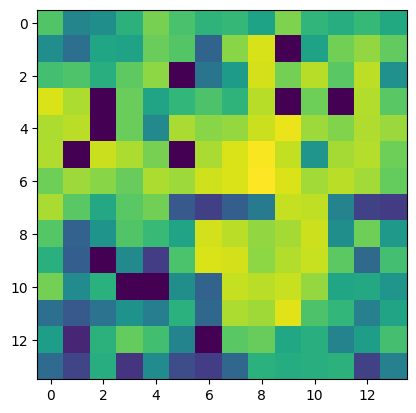

In [19]:
plt.imshow(pyx_prime[0,:,predicted_class_idx].reshape(14,14).detach().cpu().numpy())

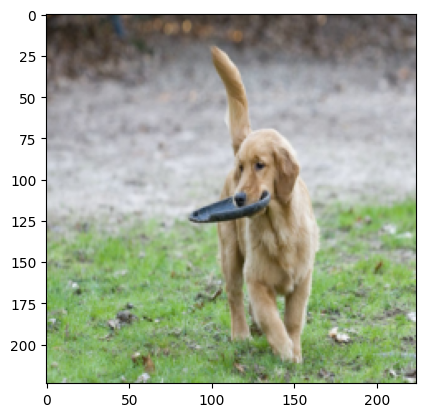

In [20]:
plt.imshow(image)

In [21]:
torch.topk(pyx_prime[0,:,predicted_class_idx], k=10)
# torch.topk(-pyx_prime[0,:,:], k=10)

torch.return_types.topk(
values=tensor([0.9458, 0.9367, 0.9166, 0.9050, 0.8954, 0.8931, 0.8930, 0.8929, 0.8915,
        0.8899], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([ 92,  78,  65, 163,  93,  91,  42,  77, 132,  22], device='cuda:0'))

In [8]:
pyx[0,:,predicted_class_idx]

tensor([0.4981], device='cuda:0', grad_fn=<SelectBackward0>)

In [9]:
(pyx - pyx_prime)[:,:,predicted_class_idx].max()

tensor(0.4962, device='cuda:0', grad_fn=<MaxBackward1>)

In [10]:
(pyx / pyx_prime)[:,:,predicted_class_idx].reshape(14,14)

tensor([[  1.0605,   0.9641,   1.0634,   1.0492,   1.0624,   1.0335,   1.0242,
           1.0554,   1.0525,   1.1920,  69.8250,   0.9804,   0.8961,   0.8441],
        [  0.9360,   1.0286,   1.0604,   1.1734,   1.1672,   1.1545,   0.9731,
           1.2005,   1.0114,   1.4464,   2.0695,   1.5905,   1.3812,   1.1033],
        [  0.9340,   1.2168,   1.0647,   1.1494,   1.5099,   1.2456,   0.8719,
           0.9707,   1.0615,   2.0175,   1.4885,   1.6913,   1.6754,   0.9872],
        [  0.8899,   1.5820,   1.2759,   2.5112,   1.7172,   1.3345,   0.9465,
           0.8317,   2.1681,   2.9934,   2.1219,   1.4668,   1.2752,   0.9235],
        [  0.8783,   0.9570,   1.6465,   1.5505,   1.5631,   1.3104,   0.8350,
           0.8982,   1.8509,   1.5177,   2.5588,   1.3200,   1.1692,   0.9280],
        [  0.7897,   1.3005,   1.6744,   1.2968,   1.1577,   1.1930,   1.3714,
           1.3039,   1.7179,   1.9975,   1.4023,   1.1415,   0.8781,   0.7989],
        [  0.7935,   1.4765,   1.6526,   1.187

In [11]:
torch.topk(logits, 10)

torch.return_types.topk(
values=tensor([[10.0115,  9.1972,  9.0824,  7.1771,  5.9918,  4.6881,  4.6255,  4.3287,
          3.8645,  3.8338]], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[285, 282, 281, 287, 284, 283, 750, 831, 721, 918]], device='cuda:0'))

In [12]:
pyx[0,:,:]

tensor([[1.1326e-05, 3.0836e-05, 9.9629e-06, 1.1719e-05, 1.3106e-05, 1.1109e-05,
         1.3435e-05, 1.6221e-05, 1.5567e-05, 2.0223e-05, 6.1221e-06, 7.7510e-06,
         9.4202e-06, 6.4406e-06, 7.4202e-06, 3.8450e-06, 6.1411e-06, 1.3722e-05,
         1.1996e-05, 9.7003e-06, 7.3426e-06, 1.3384e-05, 6.8788e-06, 1.5465e-05,
         6.4861e-06, 1.0101e-05, 1.1658e-05, 1.0394e-05, 1.2725e-05, 2.0338e-05,
         9.0826e-06, 1.0087e-05, 1.0450e-05, 6.8205e-06, 8.6562e-06, 4.3906e-06,
         1.1268e-05, 7.8148e-06, 2.2535e-05, 1.1816e-05, 5.5514e-06, 1.3643e-05,
         1.5628e-05, 4.7667e-06, 3.6236e-06, 1.2806e-05, 7.1721e-06, 7.2251e-06,
         1.3405e-05, 6.5333e-06, 6.4326e-06, 1.1777e-05, 8.5027e-06, 9.8639e-06,
         1.0848e-05, 6.5643e-06, 9.7111e-06, 1.1885e-05, 4.6081e-06, 6.8579e-06,
         2.3445e-05, 2.0298e-05, 1.6698e-05, 1.0537e-05, 6.3933e-06, 1.0232e-05,
         3.1536e-05, 1.1461e-05, 1.5971e-05, 2.4067e-05, 5.0093e-06, 1.4248e-05,
         7.3573e-06, 1.3548e

In [13]:
rec = outputs.reconstructed_pixel_values.detach().cpu().numpy()[0].transpose([1,2,0])

AttributeError: 'ImageClassifierOutput' object has no attribute 'reconstructed_pixel_values'

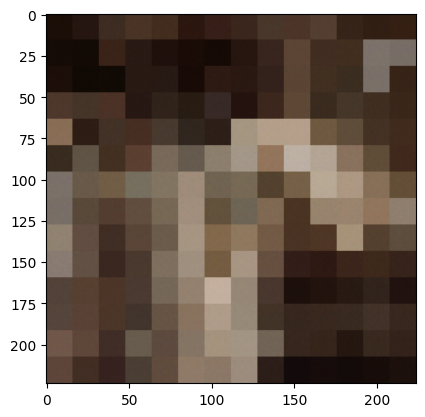

In [ ]:
plt.imshow(unnormalize(rec, mean, std))

In [ ]:
unnormalize(rec, mean, std)

array([[[0.10540667, 0.05240083, 0.02797168],
        [0.11569738, 0.05597475, 0.03093141],
        [0.10594907, 0.05498615, 0.03017637],
        ...,
        [0.20778137, 0.12514582, 0.07851222],
        [0.21154031, 0.12593618, 0.07852992],
        [0.2088823 , 0.12070447, 0.07430771]],

       [[0.1061573 , 0.05628175, 0.02942321],
        [0.10450792, 0.05424193, 0.02941111],
        [0.10662544, 0.05585095, 0.03131181],
        ...,
        [0.21154508, 0.12302908, 0.07994074],
        [0.21264869, 0.12374902, 0.0856888 ],
        [0.20503831, 0.12627873, 0.07278678]],

       [[0.1082224 , 0.05590051, 0.03275746],
        [0.10293579, 0.05539387, 0.0310069 ],
        [0.10931939, 0.05470628, 0.02703333],
        ...,
        [0.21316081, 0.12714794, 0.07588571],
        [0.21049041, 0.1234259 , 0.07906577],
        [0.20567527, 0.12627313, 0.07419285]],

       ...,

       [[0.36235309, 0.27867903, 0.23429787],
        [0.37123857, 0.2734745 , 0.22480628],
        [0.37193875, 0